In this notebook, we will implement a procedure for determining the best-fitting parametric distribution for a set of historical data. We will select the best distribution from a subset of popular parametric distributions.

The following code block imports libraries we will use.

In [1]:
import warnings

import matplotlib.ticker as mticker
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as st
import seaborn as sns
from tqdm.notebook import tqdm

The following code block:
1) reads a sample of observations using the `pandas` library,
2) prints the `shape` of the data, i.e., a tuple with the number of rows and number of columns,
3) prints the `type` of the data, which is a `pandas` `DataFrame` class, and
4) uses the `head` method to print the first five rows of the data.

Our goal is to fit a parametric distribution that closely mimics the values in the sample.

In [2]:
data = pd.read_csv('distribution_fitting_data.csv')
print(f' - {data.shape = }')
print(f' - {type(data) = }')
data.head()

 - data.shape = (1000, 1)
 - type(data) = <class 'pandas.core.frame.DataFrame'>


,observations
0,27.744545
1,9.975359
2,15.395165
3,39.672962
4,29.984138


The following code block uses the `values` attribute to obtain the values in the `observations` column as a `numpy` array.

In [3]:
observation_array = data['observations'].values

The following code block defines a function that takes a single `numpy` array as a required argument and creates a histogram for the values in the array. The histogram is defined to represent the counts for each bin as a probability instead of a frequency. Also, arguments are provided that allow you to display the mean value, the median value, or both the mean and median values.

In [4]:
def plot_single_histogram(
    observations_array: np.ndarray,
    figsize_tuple: tuple = (6, 4),
    include_mean: bool = False,
    include_median: bool = False,
):
    
    fig, ax = plt.subplots(1, 1, figsize=figsize_tuple)

    sns.histplot(
        observations_array,
        stat='probability',
    )
    if include_mean:
        ax.axvline(
            observations_array.mean(),
            label='Mean',
            color='k',
            linewidth=2,
        )
    if include_median:
        ax.axvline(
            np.percentile(observations_array, q=50),
            label='Median',
            color='k',
            linewidth=2,
            linestyle='--',
        )
    ax.spines[['right', 'top']].set_visible(False)
    if include_mean or include_median:
        ax.legend()

    plt.show()

The following code block visualizes our data using the `plot_single_histogram` function. The visualization shows that the data is right-skewed, meaning that when viewed as a histogram, the majority of the data appears to the left, with a tail extending to the right. As a result, the mean value will be greater than the median.

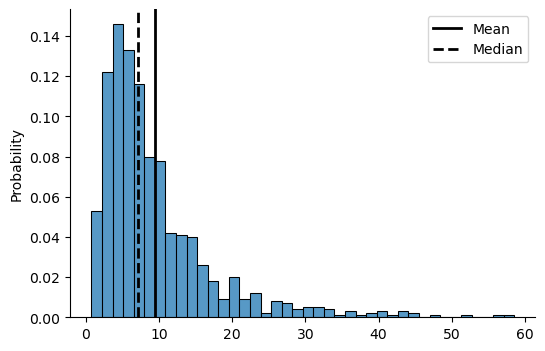

In [5]:
plot_single_histogram(
    observation_array, 
    include_mean=True, 
    include_median=True,
)

#### Process for fitting a distribution using the `scipy.stats` module

The `scipy.stats` module makes identifying the best fit for a particular type of parametric distribution to a data set very easy. First, you need to specify the type of distribution you want to fit. In the following code block, we set a variable named `my_distribution_class` to `st.norm`, corresponding to a Normal distribution in `scipy.stats`.

In [6]:
my_distribution_class = st.norm

In the following code block, I call the `.fit` method on the instantiated `my_distribution_class` and pass the data we wish to fit the distribution to as an argument. An *f-string* prints the values returned by the `.fit` method, which are stored in a variable named `my_distribution_parameters`. In particular, the `.fit` method returns a set of floating point values corresponding to parameters for the specified distribution type that best fits the data.

In [7]:
my_distribution_parameters = my_distribution_class.fit(observation_array)
print(f' - {my_distribution_parameters = }')

 - my_distribution_parameters = (9.402818245594503, 7.862035604890878)


The number of parameters returned by the `.fit` method demonstrated in the previous cell depends on the distribution being used. Once we know these parameters, which again correspond to the parameters yielding the best fit for the given data, we can use *tuple unpacking* to define a *frozen* version of the distribution, which is demonstrated in the following code block.

In [8]:
my_fitted_distribution = my_distribution_class(*my_distribution_parameters)

Now we have a fitted distribution and can use the `.rvs` methods to generate random values. The following code block generates an array of random values that is the same size as the array of observations. The `plot_single_histogram` function is used to show the distribution of the generated values.

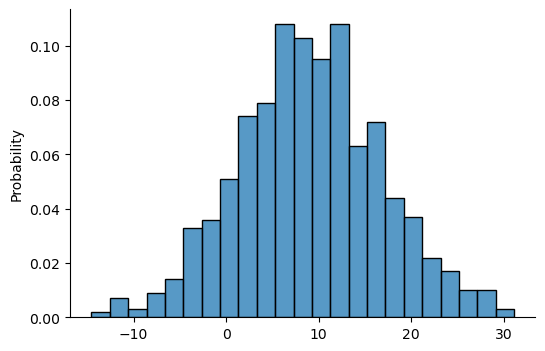

In [9]:
np.random.seed(0)
my_rvs = my_fitted_distribution.rvs(len(observation_array))

plot_single_histogram(
    my_rvs,
)

The following code block defines a function that compares the distributions of two arrays provided as arguments.

In [10]:
def compare_two_distributions(
    observations_array1: np.ndarray,
    observations_array2: np.ndarray,
    observations_array1_label: str = 'Array 1',
    observations_array2_label: str = 'Array 2',
    figsize_tuple: tuple = (6, 4),
):
    
    fig, ax = plt.subplots(1, 1, figsize=figsize_tuple)

    sns.histplot(
        observations_array1,
        stat='probability',
        label=observations_array1_label,
    )
    sns.histplot(
        observations_array2,
        stat='probability',
        label=observations_array2_label,
    )
    ax.spines[['right', 'top']].set_visible(False)
    ax.legend()

    plt.show()

The following code block uses the `compare_two_distributions` function to compare the distributions for the observations included in `observation_array` and the randomly generated values in `my_rvs`. The plot shows that the two distributions are quite different, which indicates that a Normal distribution may not be a good choice for approximating the data stored in `observation_array`.

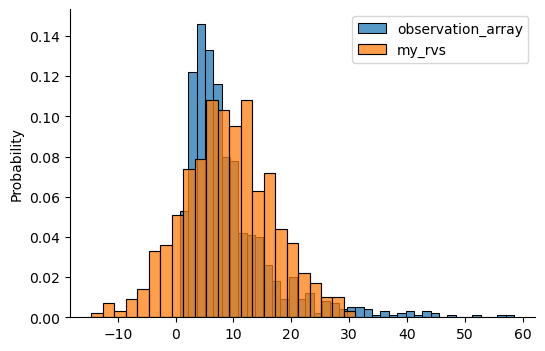

In [11]:
compare_two_distributions(
    observations_array1=observation_array,
    observations_array2=my_rvs,
    observations_array1_label='observation_array',
    observations_array2_label='my_rvs',
)

The following code block uses the Kolmogorov-Smirnov (KS) test to obtain a statistic measuring the *goodness-of-fit* for the two samples. You can find more information on the KS test and the returned test statistic at https://en.wikipedia.org/wiki/Kolmogorov-Smirnov_test. Lower values of the returned statistic indicate the distributions of the two samples are more similar.

In [12]:
ks_results = st.ks_2samp(observation_array, my_rvs)
ks_statistic = ks_results.statistic
print(f' - {ks_statistic = }')

 - ks_statistic = 0.143


The following code block repeats the distribution fitting process using a Beta distribution instead of a Normal distribution to demonstrate the behavior of the KS test statistic. We are filtering warnings from the `scipy.stats` function calls since we cannot control them. The plot shows that the Beta distribution is a much better fit and results in a much lower value for the KS statistic.

 - ks_statistic = 0.054


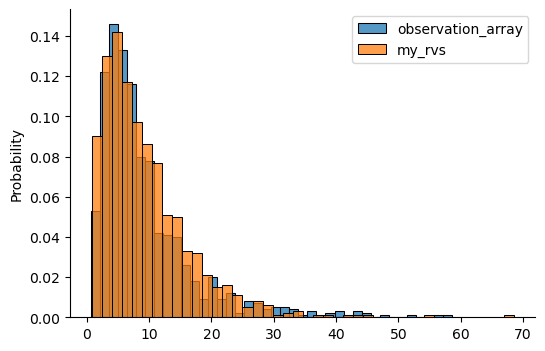

In [13]:
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    
    my_distribution_class = st.beta
    my_distribution_parameters = my_distribution_class.fit(observation_array)
    my_fitted_distribution = my_distribution_class(*my_distribution_parameters)

    np.random.seed(0)
    my_rvs = my_fitted_distribution.rvs(len(observation_array))
    ks_results = st.ks_2samp(observation_array, my_rvs)
    ks_statistic = ks_results.statistic

print(f' - {ks_statistic = }')

compare_two_distributions(
    observations_array1=observation_array,
    observations_array2=my_rvs,
    observations_array1_label='observation_array',
    observations_array2_label='my_rvs',
)

Up to this point, we have seen how to fit a Normal distribution and a Beta distribution to the observations. The `scipy.stats` library has many other choices. The following code block defines a list of common distribution types defined in the module.

In [14]:
distributions_to_check = [
    st.beta, # beta
    st.expon, # exponential
    st.gamma, # gamma
    st.lognorm, # lognormal
    st.norm, # normal
    st.triang, # triangular
    st.uniform, # uniform
]

The following code block defines a simple search algorithm that iterates over the distributions in the `distributions_to_check` object to identify the best-fitting distribution. A frozen version of the best-fitting distribution is stored in the `best_distribution` object, and the corresponding KS statistic value is stored in the `best_KS` variable.

 - best_KS = 0.032
 - best_distribution.dist.name = 'lognorm'


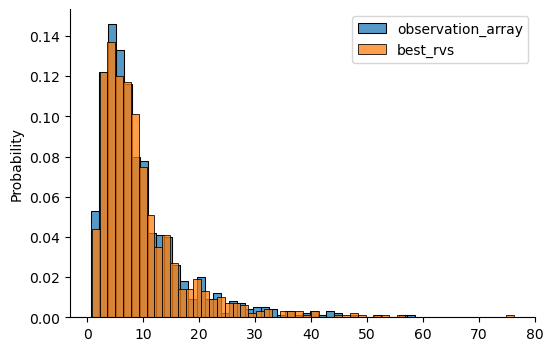

In [15]:
best_KS = np.inf
best_distribution = None

for current_distribution in distributions_to_check:
    
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')
        
        distribution_parameters = current_distribution.fit(observation_array)
        fitted_distribution = current_distribution(*distribution_parameters)
    
        np.random.seed(0)
        my_rvs = fitted_distribution.rvs(len(observation_array))
        ks_results = st.ks_2samp(observation_array, my_rvs)
        ks_statistic = ks_results.statistic
        
        if ks_statistic < best_KS:
            best_KS = ks_statistic
            best_distribution = fitted_distribution

print(f' - {best_KS = }')
print(f' - {best_distribution.dist.name = }')

best_rvs = best_distribution.rvs(len(observation_array))

compare_two_distributions(
    observations_array1=observation_array,
    observations_array2=best_rvs,
    observations_array1_label='observation_array',
    observations_array2_label='best_rvs',
)